# Skull Stripping Segmentation NFBS Data

My plan is to use the Neurofeedback Skull-stripped (NFBS) dataset to train a 3D UNet model on that. Then use that trained 3D UNet model to do automated skull stripping on the ATLAS 2.0 dataset later in our lesion segmentation notebook and source code. Skull stripping is a preprocessing step before lesion segmentation.

`Skull Stripping 3D UNet Tutorial` Referenced: https://www.analyticsvidhya.com/blog/2021/06/introduction-to-skull-stripping-image-segmentation-on-3d-mri-images/

`MRI Brain Dataset` for training and library with skull stripped labels: http://preprocessed-connectomes-project.org/NFB_skullstripped/

`ANT Library` and `T1w MRI Test set` can be found here at Kaggle: https://www.kaggle.com/code/prashanthsheri/nfbs-data-set/data?select=ANTs-28-03-2019.7z

## NFBS Dataset

- 125 participants 21 to 45 years old with a variety of clinical and sub-clinical psychiatric symptoms.
- Structural T1-weighted anonymized (de-faced) images) with a single channel.
- Brain mask is the ground truth obtained using Beast (Brain extraction based on nonlocal segmentation) method and applying manual edits by domain experts to remove non-brain tissue.
- Skull-stripped image is part of the brain stripped from T1 weighted image. It is similar to overlaying masks to actual images.
- The resolution is 1 mm3 and each file is NiFTI (.nii.gz) format.

## Outline

- Prepare NFBS Data
- 3D UNet Model Architecture
- Train 3D UNet Model
- Deploy 3D UNet for Skull Stripping

## Install Packages

In [ ]:
#for handling MRI images
# !pip install nipype
# !pip install antspyx
# !pip install nilearn
# !pip install SimpleITK

#for segmentation
# keras comes with tensorflow
# !pip install q # keras==2.3.1
# !pip install segmentation-models

# Might not need ANTS lib. Do I replace it with BEast Lib?
#for running ANTS library in colab
# !7z x ANTs-28-03-2019.7z
# !cp bin/* /usr/local/bin

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nibabel.testing import data_path
import os
import nibabel as nib
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import segmentation_models as sm
from segmentation_models.metrics import iou_score
focal_loss = sm.losses.cce_dice_loss
from nipype.interfaces.slicer.filtering.n4itkbiasfieldcorrection import N4ITKBiasFieldCorrection
from nipype import Node, Workflow
from nilearn.image import resample_img
from sklearn.model_selection import train_test_split
import random
import SimpleITK as sitk
from nilearn.image import math_img
from nilearn import image as nii
from nilearn import plotting
from nipype.interfaces.ants import N4BiasFieldCorrection

2022-11-18 10:58:02.720955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 10:58:03.305117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-11-18 10:58:03.305199: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-18 10:58:03.385307: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 10:58:04.486

Segmentation Models: using `keras` framework.


In [20]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Prepare NFBS Data

Make sure to extract NFBS_Dataset.tar.gz with `tar -xvf NFBS_Dataset.tar.gz` or similar tool.

In [3]:
nfbs_path = "/media/james/My Passport/NFBS_Dataset"
# voxel is a 3D MRI object can be split into MRI 2D slice images
voxel = nib.load("{}/A00028185/sub-A00028185_ses-NFB3_T1w.nii.gz".format(nfbs_path))

print("Shape of voxel=", voxel.shape)

Shape of voxel= (256, 256, 192)


We can see our 3D MRI voxel also can be thought of as a 3D object containing 192 MRI 2D slice images where each image is 256*256. You can think of these images stacked on top of each other.

We will create a data frame that contains the location of images and their corresponding masks and skull-stripped images

In [4]:
# store the address of 3 types of files
brain_mask = list()
brain = list()
raw = list()

for subdir, dirs, files in os.walk(nfbs_path):
    for file in files:
        # print(os.path.join(subdir, file))
        filepath = subdir + os.sep + file
        
        if filepath.endswith(".gz"):
            if "_brainmask." in filepath:
                brain_mask.append(filepath)
            elif "_brain." in filepath:
                brain.append(filepath)
            else:
                raw.append(filepath)

In [11]:
nfbs_df = pd.DataFrame(
    {"brain_mask": brain_mask,
     "brain": brain,
     "raw": raw
    }
)

In [13]:
nfbs_df.head()

,brain_mask,brain,raw
0,/media/james/My Passport/NFBS_Dataset/A0004372...,/media/james/My Passport/NFBS_Dataset/A0004372...,/media/james/My Passport/NFBS_Dataset/A0004372...
1,/media/james/My Passport/NFBS_Dataset/A0005609...,/media/james/My Passport/NFBS_Dataset/A0005609...,/media/james/My Passport/NFBS_Dataset/A0005609...
2,/media/james/My Passport/NFBS_Dataset/A0006025...,/media/james/My Passport/NFBS_Dataset/A0006025...,/media/james/My Passport/NFBS_Dataset/A0006025...
3,/media/james/My Passport/NFBS_Dataset/A0002818...,/media/james/My Passport/NFBS_Dataset/A0002818...,/media/james/My Passport/NFBS_Dataset/A0002818...
4,/media/james/My Passport/NFBS_Dataset/A0002835...,/media/james/My Passport/NFBS_Dataset/A0002835...,/media/james/My Passport/NFBS_Dataset/A0002835...


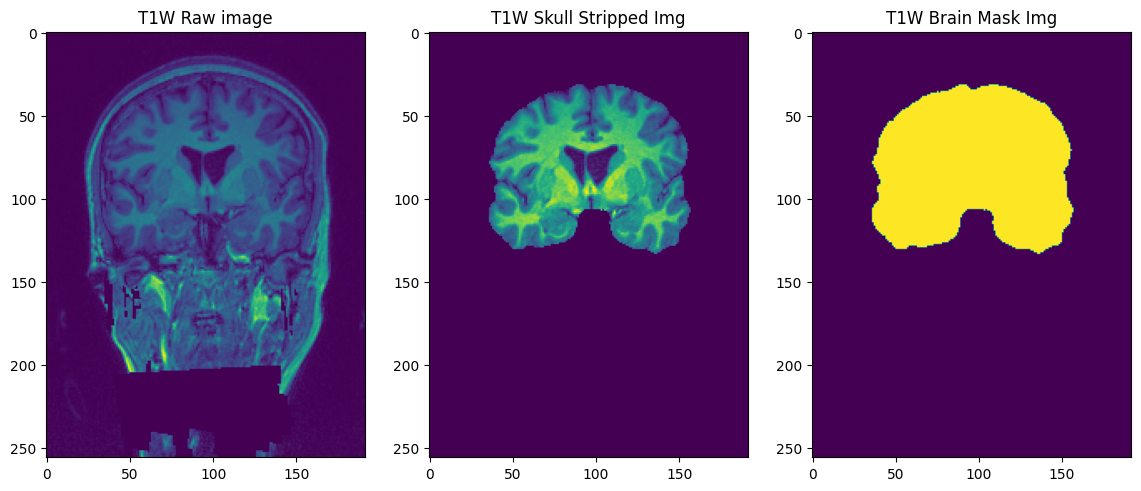

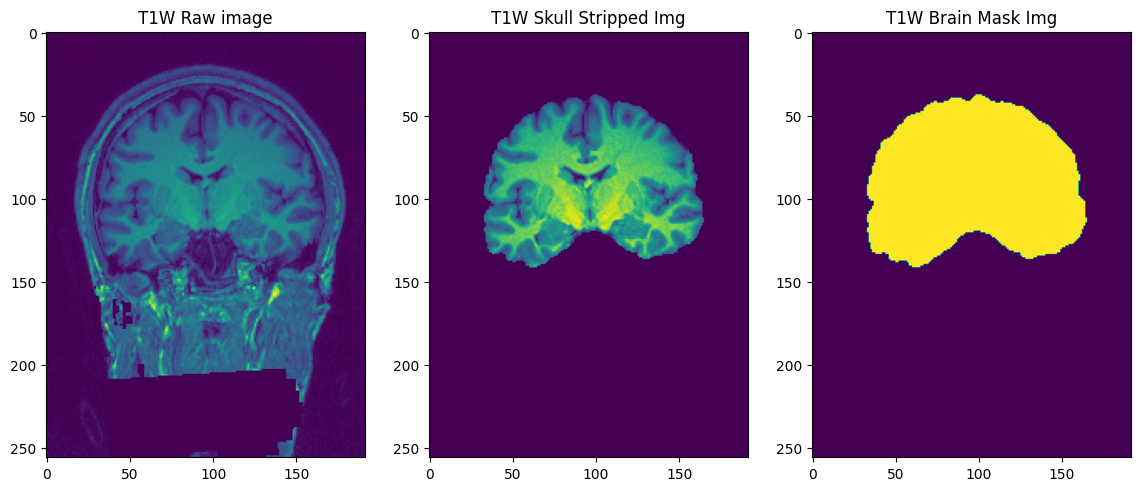

In [21]:
# visualize a couple of examples
for i in range(2):
    fig, ax = plt.subplots(1, 3, figsize=(14, 10))
    ax[0].set_title("T1W Raw image")
    img = nib.load(nfbs_df.raw.iloc[i]).get_data()
    ax[0].imshow(img[img.shape[0]//2])
    ax[1].set_title("T1W Skull Stripped Img")
    img = nib.load(nfbs_df.brain.iloc[i]).get_data()
    ax[1].imshow(img[img.shape[0]//2])
    ax[2].set_title("T1W Brain Mask Img")
    img = nib.load(nfbs_df.brain_mask.iloc[i]).get_data()
    ax[2].imshow(img[img.shape[0]//2])

The next preparation steps we'll perform are:

- Bias field correction: bias field signal is a low-frequency and smooth signal that corrupts MRI images especially those produced by old MRI machines. Thus, bias field correction is done on MRIs prior to pushing them into image processing algorithms: segmentation, texture analysis, classification.
- Cropping and resizing: due to computational limits of fitting image to model, we reduce MRI image size from (`256*256*192`) to (`96*128*160`). The target size is chosen in a way where most of the skull is captured after cropping and resizing it has a centering effect on images.
- Intensity normalization: shifts and scales an image so the pixels have a zero mean and unit variance. This helps the model converge faster by removing scale in-variance.
- Data Generator to Feed Data to Model: First we do a train and test split. Then we use a custom data generator to feed the input MRIs into the model (TODO: update this part).

In [15]:
class preprocessing():
    def __init__(self, df):
        self.data = df
        self.raw_index = list()
        self.mask_index = list()
    def bias_correction(self):
        bias_dir = "bias_correction"
        bias_path = os.path.join(nfbs_path, bias_dir)
        if not os.path.exists(bias_path):
            os.makedirs(bias_path)
        n4 = N4BiasFieldCorrection()
        n4.inputs.dimensions = 3
        n4.inputs.shrink_factor = 3
        n4.inputs.n_iterations = [20, 10, 10, 5]
        index_corr = list()
        for i in tqdm(range(len(self.data))):
            n4.inputs.input_image = self.data.raw.iloc[i]
            n4.inputs.output_image = bias_dir + os.sep + str(i) + ".nii.gz"
            index_corr.append(bias_dir + os.sep + str(i) + ".nii.gz")
            res = n4.run()
        index_corr = [bias_dir + os.sep + str(i) + ".nii.gz" for i in range(125)]
        data["bias_corr"] = index_corr
        print("bias corrected voxels stored at : {}/".format(bias_dir))
    def resize_crop(self):
        # reducing the size of image due to memory constraints
        self.rcrop_dir = "resized"
        rcrop_path = os.path.join(nfbs_path, rcrop_dir)
        #reducing size of image from 256*256*192 to 96*128*160
        target_shape = np.array((96,128,160))
        new_resolution = [2,]*3
        new_affine = np.zeros((4,4))
        new_affine[:3,:3] = np.diag(new_resolution)
        # putting point 0,0,0 in the middle of the new volume - this
        # could be refined in the future
        new_affine[:3,3] = target_shape*new_resolution/2.*-1
        new_affine[3,3] = 1.
        raw_index = list()
        mask_index = list()
        # resizing both image and mask and storing in folder
        for i in range(len(data)):
            downsampled_and_cropped_nii = resample_img(
                self.data.data_corr.iloc[i], target_affine=new_affine,
                target_shape=target_shape, interpolation="nearest")
            downsampled_and_cropped_nii.to_filename(
                rcrop_dir + os.sep + "raw" + str(i) + ".nii.gz")
            self.raw_index.append(rcrop_dir + os.sep + "raw" + str(i) + ".nii.gz")
            
            downsampled_and_cropped_nii = resample_img(
                self.data.brain_mask.iloc[i], target_affine=new_affine,
                target_shape=target_shape, interpolation="nearest")
            downsampled_and_cropped_nii.to_filename(
                rcrop_dir + os.sep + "mask" + str(i) + ".nii.gz")
            self.mask_index.append(rcrop_dir + os.sep + "mask" + str(i) + ".nii.gz")
        return self.raw_index, self.mask_index
    
    def intensity_normalization(self):
        for i in self.raw_index:
            image = sitk.ReadImage(i)
            resacleFilter = sitk.RescaleIntensityImageFilter()
            resacleFilter.SetOutputMaximum(255)
            resacleFilter.SetOutputMinimum(0)
            image = resacleFilter.Execute(image)
            sitk.WriteImage(image, i)
        print("Normalization done. Voxels stored at: {}/".format(self.rcrop_dir))

    def data_gen(self, img_list, mask_list, batch_size):
        '''Custom data generator to feed MRIs to model'''
        c = 0
        # List of training MRIs
        n = [i for i in range(len(img_list))]
        random.shuffle(n)
        
        while(True):
            # adding extra dimensions as conv3d takes file of size 5
            img = np.zeros((batch_size, 96, 128, 160, 1)).astype("float")
            mask = np.zeros((batch_size, 96, 128, 160, 1)).astype("float")
            
            for i in range(c, c+batch_size):
                train_img = nib.load(img_list[n[i]]).get_data()
                
                train_img = np.expand_dims(train_img, -1)
                train_mask = nib.load(mask_list[n[i]]).get_data()
                
                train_mask = np.expand_dims(train_mask, -1)
                
                img[i-c] = train_img
                mask[i-c] = train_mask
            c += batch_size
            if(c+batch_size >= len(img_list)):
                c=0
                random.shuffle(n)
            
            yield img,mask

## 3D UNet Model Architecture

We've built our preprocessing class, we can begin modeling. 

- First we have a contracting path via an encoder that gradually reduces the size of the image and the number of filters is increased to generate bottleneck features.
- This is then fed into a decoder block that gradually expands the size so that finally it can generate a mask as predicted output.

![bai_dash_residual_3d_unet_arch](./bai_dash_residual_3d_unet_arch.png)

- Figure: Residual 3D UNet. Credit: Bai Dash from referenced tutorial

In [16]:
def convolutional_block(input, filters=3, kernel_size=3, batchnorm=True):
    '''conv layer followed by batchnormalization'''
    x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [17]:
def resunet_opt(input_img, filters=64, dropout=0.2, batchnorm=True):
    """Residual 3D UNet"""
    conv1 = convolutional_block(input_img, filters*1,kernel_size=3,
                               batchnorm=batchnorm)
    pool1 = MaxPooling3D((2,2,2))(conv1)
    drop1 = Dropout(dropout)(pool1)
    
    conv2 = convolutional_block(drop1, filters*2, kernel_size=3,
                               batchnorm=batchnorm)
    pool2 = MaxPooling3D((2,2,2))(conv2)
    drop2 = Dropout(dropout)(pool2)
    
    conv3 = convolutional_block(drop2, filters*4, kernel_size=3,
                               batchnorm=batchnorm)
    pool3 = MaxPooling3D((2,2,2))(conv3)
    drop3 = Dropout(dropout)(pool3)
    
    conv4 = convolutional_block(drop3, filters*8, kernel_size=3, 
                                batchnorm=batchnorm)
    pool4 = MaxPooling3D((2,2,2))(conv4)
    drop4 = Dropout(dropout)(pool4)
    
    conv5 = convolutional_block(drop4, filters=filters*16, kernel_size=3,
                               batchnorm=batchnorm)
    conv6 = convolutional_block(conv5, filters=filters*16, kernel_size=3,
                               batchnorm=batchnorm)
    
    ups6 = Conv3DTranspose(filters*8, (3,3,3), strides=(2,2,2), padding="same",
                          activation="relu", kernel_initializer="he_normal")(conv5)
    ups6 = concatenate([ups6, conv4])
    ups6 = Dropout(dropout)(ups6)
    conv6 = convolutional_block(ups6, filters*8, kernel_size=3,
                               batchnorm=batchnorm)
    
    ups7 = Conv3DTranspose(filters*4, (3,3,3), strides=(2,2,2), padding="same",
                          activation="relu", kernel_initializer="he_normal")(conv6)
    ups7 = concatenate([ups7, conv3])
    ups7 = Dropout(dropout)(ups7)
    conv7 = convolutional_block(ups7, filters*4, kernel_size=3,
                               batchnorm=batchnorm)
    
    ups8 = Conv3DTranspose(filters*2, (3,3,3), strides=(2,2,2), padding="same",
                          activation="relu", kernel_initializer="he_normal")(conv7)
    ups8 = concatenate([ups8, conv2])
    ups8 = Dropout(dropout)(ups8)
    conv8 = convolutional_block(ups8, filters*2, kernel_size=3,
                               batchnorm=batchnorm)
    
    ups9 = Conv3DTranspose(filters*1, (3,3,3), strides=(2,2,2), padding="same",
                          activation="relu", kernel_initializer="he_normal")(conv8)
    ups9 = concatenate([ups9, conv1])
    ups9 = Dropout(dropout)(ups9)
    conv9 = convolutional_block(ups9, filters*1, kernel_size=3, 
                               batchnorm=batchnorm)
    
    outputs = Conv3D(1, (1,1,2), activation="sigmoid", padding="same")(conv9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## Train 3D UNet Model

We will train 3D UNet using Adam optimizer and dice loss function.

In [ ]:
# training function part of preprocessing class
def training(self, epochs):
    im_height=96
    im_width=128
    img_depth=160
    epochs=60 # epochs = 60
    train_gen = data_gen(self.X_train, self.y_train, batch_size=4)
    val_gen = data_gen(self.X_test, self.y_test, batch_size=4)
    channels=1
    input_img = Input((im_height, im_width, img_depth, channels), name="img")
    self.model = resunet_opt(input_img, filters=16, dropout=16, dropout=0.05, 
                             batchnorm=True)
    self.model.summary()
    self.model.compile(optimizer=Adam(lr=1e-1), loss=focal_loss,
                      metrics=[iou_score, "accuracy"])
    # fitting the model
    callbacks = callbacks = [
        ModelCheckpoint("best_model.h5", verbose=1, save_best_only=True,
                       metrics=[iou_score, "accuracy"])
    ]
    result = self.model.fit(train_gen, steps_per_epoch=16, epochs=epochs,
                           validation_data=val_gen, validation_steps=16,
                           initial_epoch=0, callbacks=callbacks)

After training for 60 epochs, we should get validation iou_score = 0.86